# Source Catalog: Loading, Plotting and Exploring Examples

In [1]:
import numpy as np
import os.path as op
import requests

from astropy.table import Table, unique

from hetdex_tools.source_catalog import plot_source_group
from hetdex_api.elixer_widget_cls import ElixerWidget
from hetdex_api.query_widget import QueryWidget
from hetdex_api.amp_widget import AmpWidget
from hetdex_api.config import HDRconfig

## Changes to 5.0.2

* Note that the best detectid is chosen for all sources based on the brightest (minimizes gmag) detection. For OII and AGN and this can result in continuum detections being selected. For this reason a strict wavelength or sn cut (which are both 0 for continuum sources) will exclude the entire source. Suggested cuts are given below

* flux_lya, flux_oii, lum_lya, lum_oii are the suggested columns to access the appropriate continuum-subtracted line flux values.

This catalog is a combination of sources from the continuum source catalog, the curated detection line catalog of the same version and the confirmed AGN detection IDs from Chenxu Liu's AGN search. A source_id is assigned to a group of detections that are first matched in 3D space through FOF clustering in RA/DEC/WAVE at a linking length of 6 arcsec and 6 AA in the spectral direction. FOF grouping of detections close on sky is done at a smaller linking length of 3AA. This can result in some background sources getting sweeped into a foreground object. Sources in repeat observation are NOT grouped together into one source_id. The column 'line_id' will identify a line species for a specific line emission detection if it is an observed wavelength match to the line given the determined redshift (z_hetdex) of a source. 

The column `'det_type'` can be `['line','cont','agn']`. The column "source_type" describes the source classifcation 'agn','lae', 'oii', 'star', 'lzg'(low-z galaxy without line emission), 'unsure' and 'z_hetdex' provides the best redshift which is a combination of Diagnose redshifts (g<22), Elixer redshifts (g>22) and AGN redshifts. Please read the first public source catalog paper for more info  https://iopscience.iop.org/article/10.3847/1538-4357/aca962.

Please report issues to Erin at erin_@_astro.

### Column Info can be found here:


https://op1srv.mpe.mpg.de/wikihetdex/index.php/Column_Info


## Open the catalog. We can use HDRconfig to identify the system path

New for 5.0.2: flux_lya/lum_lya and flux_oii/lum_oii are the columns to use for flux/lum values. The best detection selection (selected_det==True/ flag_seldet==1) now selects the brightest detection (ie minimizes gmag column). Selecting on line_id=='LyA' or wave will remove good sources since in some cases the brightest detectid is not a Lyalpha detection line. For example the pipeline has an upper limit cutoff on counts.

In [2]:
# Enter the catalog version

version = '5.0.2'
hdrv = 'hdr{}'.format(version[0])
config = HDRconfig()
catfile = op.join(config.hdr_dir[hdrv], 'catalogs', 'source_catalog_' + version + '.fits')
source_table = Table.read(catfile)

print('Source catalog was found at {}'.format(catfile))

Source catalog was found at /scratch/projects/hetdex/hdr5/catalogs/source_catalog_5.0.2.fits


## 5.0.2 ERIN Suggested LAE cuts

In [3]:
sel_best = (source_table['flag_best']==1) * (source_table['flag_seldet'] == 1) * (source_table['flag_shot_cosmology']==1)
sel_lae =  (source_table['z_hetdex'] >= 1.87) * (source_table['z_hetdex']<=3.53)

sel_erin = sel_best*sel_lae

lae_sample = source_table[sel_erin]

In [4]:
len(lae_sample)

1643866

# OLD Karl's LAE Cosmology Sample Cuts

In [5]:
# suggested LAE cut by KARL, this will not include certain AGN  (~1300 so that’s 12% of the AGN with Lya sample)

In [6]:
sel_best = (source_table['flag_best']==1) * (source_table['flag_seldet'] == 1) * (source_table['flag_shot_cosmology']==1)
sel_lae =  (source_table['z_hetdex'] >= 1.87) * (source_table['z_hetdex']<=3.53)* (source_table['line_id']=='Lya')
sel_apcor = (source_table['apcor'] > 0.4)
sel_lya = np.abs(source_table['wave'] - (1215.67*(1+source_table['z_hetdex']))) <= 10

In [7]:
sel_karl = sel_best * sel_lae * sel_apcor * sel_lya

In [8]:
np.sum(sel_karl)

1638775

# Additional Confidence Cuts

Currently we find that CNN_Score_2DSpectra, sn_rres, p_conf (above S/N>5.5) appear to provide good cuts to improve the confidence of the sample. We suggest you play with the CNN_Score_2DSpectra and sn_rres thresholds. The higher the value the more confident, but the lower the numbers.

### Suggested in PDR1 Public Release Catalog

In [9]:
sel_cut1 = lae_sample['p_conf'] >= 0.5
sel_cut2 = lae_sample['CNN_Score_2D_Spectra'] >= 0.5
sel_cuts_pdr1 = sel_cut1 * sel_cut2 

print( np.sum(sel_cuts_pdr1))

417625


In [10]:
ElixerWidget(detectlist = lae_sample['detectid'][ sel_cuts_pdr1][-1000:])

interactive(children=(Text(value='5003874228', description='DetectID', placeholder='5003874228'), Output()), _…

### Most Pristine Sample

In [11]:
# small sample with maximum Plank Cross-correlation S/N by Akinori Matsumoto
#(SN cut, CNN cut, P_conf cut)=(5.5, 0.9, 0.2).

In [12]:
# Note that since continuum sources can be the selected detectid (flag_seldet=1), it is important to ensure a S/N cut does
# not remove them as they have sn=0 in the catalog

sel_cut1 = (lae_sample['sn'] >= 5.5) | (lae_sample['det_type']=='cont')
sel_cut2 = lae_sample['p_conf'] >= 0.2
sel_cut3 = lae_sample['CNN_Score_2D_Spectra'] >= 0.9
sel_cuts_pristine = sel_cut1 * sel_cut2 * sel_cut3

In [13]:
ElixerWidget(detectlist = lae_sample['detectid'][ sel_cuts_pristine][-1000:])

interactive(children=(Text(value='5003598508', description='DetectID', placeholder='5003598508'), Output()), _…

## LyA and OII flux values

The OII and LyA flux values are populated in the flag_seldet==1 row from the appropriate measure. Please see the PDR1 paper for details. For OII galaxies these can be resolved aperture measurements and for AGN these values are taken from Chenxu's AGN catalog.

In [31]:
# Relevant fluxes are found in
source_table['source_type','flux_lya', 'flux_oii', 'lum_lya', 'lum_oii']

source_type,flux_lya,flux_oii,lum_lya,lum_oii
bytes10,float64,float64,float64,float64
lae,32.249694490230645,0.0,1.250391648101584e+43,0.0
star,0.0,0.0,0.0,0.0
star,0.0,0.0,0.0,0.0
star,0.0,0.0,0.0,0.0
star,0.0,0.0,0.0,0.0
lae,31.166639755320418,0.0,9.899006868791282e+42,0.0
lae,133.70853219827129,0.0,3.6709864008794956e+43,0.0
lae,92.35737525807109,0.0,2.4156858598715455e+43,0.0
star,0.0,0.0,0.0,0.0


# OII Cosmology Sample Cuts

The OII sample is already quite robust (FP contamination of 2% and LAE/other-z contamination of less than 1%) with only low S/N (sn<5.5) detections having contamination issues. We suggest this code bit to down-select your OII sample.

In [15]:
sel_line = (source_table['det_type'] =='line') & (source_table['sn'] >= 4.8) & (source_table['selected_det'] == True) 
sel_cont = (source_table['det_type'] == 'cont') &  (source_table['selected_det'] == True) 

sel_good = (source_table['flag_best'] == 1) 
sel_det = source_table['selected_det'] == True #flag_seldet==1
sel_cosmo_shot = (source_table['flag_shot_cosmology']==1)
sel_oii = sel_good * sel_cosmo_shot * sel_det * (sel_line | sel_cont) * (source_table['source_type']=='oii')

In [16]:
np.sum(sel_oii)

567600

## Additional Confidence Cuts

These are some suggested selections to make the sample more robust.

In [17]:
sel_pconf = source_table['p_conf'] >= 0.5
sel_cnn = source_table['CNN_Score_2D_Spectra'] >= 0.5

print(np.sum(sel_oii * sel_cnn * sel_pconf))

488619


### NEW!!! We will continue to update the bad detection list on github. These can be removed from the catalog using this cell.

# set to true to update flags for all newly found bad detects since catalog release
update_baddets = True

if update_baddets:
    current_good_dets = np.array(source_table['detectid'][source_table['flag_baddet'] == 1])
    baddets = np.array( [int(det) for det in requests.get('https://raw.githubusercontent.com/HETDEX/hetdex_api/master/known_issues/hdr3/baddetects.list').text.split('\n')])
    
    update_these_dets = np.intersect1d( current_good_dets, baddets)

    for baddet in update_these_dets:
        #print('Updating flag for {}'.format(baddet))
        sel_det = source_table['detectid'] == baddet
        if source_table['flag_baddet'][sel_det] == 1:
            source_table['flag_baddet'][sel_det] = 0
            source_table['flag_best'][sel_det] = 0

You can sort the table using the `unique` function from `astropy.table` on the `source_id` key. For nearby galaxies, stars and AGN, many detectids can comprise the same source (ie. the same `source_id`). When you reduce the catalog using the `unique` function, only 1 detectid remains for the source. It is sorted such that the source with a wavelength matching the `z_guess` value is selected and the detectid is located close to the positional center of the source group. 

In [20]:
# selecting for S/N>=5.5 line sources and all continuum + AGN sources
sel_sn = (source_table['sn'] >= 5.5) & (source_table['det_type'] == 'line')

sel_good = (source_table['flag_best'] == 1) 

sel_det = source_table['selected_det'] == True
sel_agn = source_table['source_type']=='agn'
sel_cont = source_table['det_type'] == 'cont'

sel_cat = (sel_sn | sel_cont | sel_agn) & sel_det & sel_good
uniq_table = unique(source_table[sel_cat], keys='source_id')

In [21]:
star = uniq_table['source_id'][uniq_table['source_type'] == 'star']
oii = uniq_table['source_id'][uniq_table['source_type'] == 'oii']
lae = uniq_table['source_id'][uniq_table['source_type'] == 'lae']
agn = uniq_table['source_id'][uniq_table['source_type'] == 'agn']
lzg = uniq_table['source_id'][uniq_table['source_type'] == 'lzg']

print('There are {} low-z gals, {} stars, {} OII emitters, {} AGN, and {} LAEs'. \
      format(np.size(lzg), np.size(star), np.size(oii), np.size(agn), np.size(lae)))

There are 17995 low-z gals, 143084 stars, 387868 OII emitters, 18910 AGN, and 248240 LAEs


## Here is an example of plotting a group

In [22]:
%matplotlib inline

Cutout is empty or simple gradient. Will deliberately fail cutout request. /scratch/projects/hetdex/imaging/hsc/image_tract_patch/16971/calexp-HSC-R-16971-00.fits


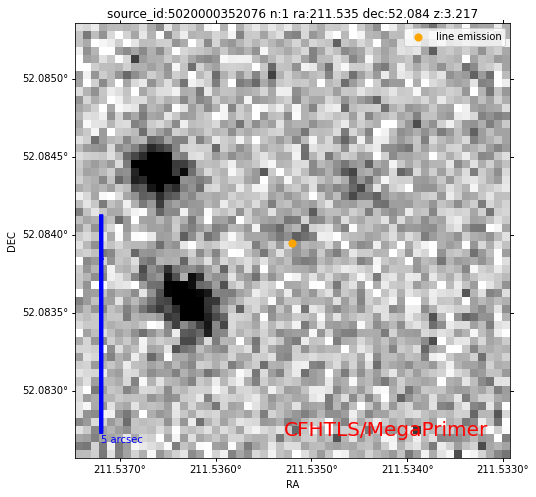

interactive(children=(Text(value='3003060882', description='DetectID', placeholder='3003060882'), Output()), _…

In [23]:
# the source_ids are sorted by member number ('n_member' in the catalog)
# This is how many detections are found in the source_id group

# Here's a query for high S/N LAEs
sel = (uniq_table['source_type'] == 'lae') & (uniq_table['sn'] > 6.5)
sid = uniq_table['source_id'][sel][9505]

# Index a star 
#sid = star[100]

# Index an OII galaxy
#sid = oii[0]

# Index an LAE
#sid = lae[0]

# Index the AGN list:
#sid = agn[0]

# This step grabs the source group so we can look at each source in Elixer
sel_group = (source_table['source_id'] == sid) 
group = source_table[sel_group]

#print(sid)
#print(group)

# this function overplots the source group over an image
# use label=True to see detectid's on image
# use save=True to save the image to you working directory
# the size of the line emission is scaled to the S/N of the line

plot_source_group(source_id = sid, source_table = source_table, label = False, save = False)
EW = ElixerWidget(detectlist = source_table['detectid'][sel_group])

## Follow a detection in the 2D image with AmpWidget 

This will map the detectid from the ElixerWidget above to the amp widget. The detection's highest weight fiber is marked with a red circle at the emission line wavelength.

In [24]:
AW = AmpWidget(detectid = EW.detid)

## Follow up with QueryWidget

You can extract fibers on demand around the detection via QueryWiget:

In [25]:
QW = QueryWidget(detectid = EW.detid)